<a href="https://colab.research.google.com/github/narayan-bhattarai/AI-Classification/blob/main/GastroVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

# Path to your ZIP file in Drive (update the path if needed)
zip_path = "/content/drive/MyDrive/GastroVision.zip"

import zipfile
import os

extract_path = "/content/GastroVision"
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction completed!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extraction completed!


In [6]:
!pip install torch torchvision scikit-learn grad-cam


In [7]:
from torchvision import transforms

train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


In [8]:
import os
DATA_DIR = "/content/GastroVision/GastroVision"
os.listdir(DATA_DIR)


['Erythema',
 'Normal esophagus',
 'Normal mucosa and vascular pattern in the large bowel',
 'Colon polyps']

In [9]:
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
import numpy as np

full_dataset = ImageFolder(DATA_DIR, transform=train_tfms)
targets = full_dataset.targets
indices = np.arange(len(full_dataset))

train_idx, val_idx = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=42
)

train_ds = Subset(full_dataset, train_idx)
val_ds = Subset(full_dataset, val_idx)
val_ds.dataset.transform = val_tfms  # apply val transforms

print("Classes:", full_dataset.classes)


Classes: ['Colon polyps', 'Erythema', 'Normal esophagus', 'Normal mucosa and vascular pattern in the large bowel']


In [11]:
from torch.utils.data import WeightedRandomSampler
from collections import Counter

train_targets = [targets[i] for i in train_idx]
class_counts = Counter(train_targets)

sample_weights = [1.0 / class_counts[t] for t in train_targets]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [12]:
import torch
import torch.nn as nn
from torchvision.models import mobilenet_v3_large, MobileNet_V3_Large_Weights

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = MobileNet_V3_Large_Weights.IMAGENET1K_V1
model = mobilenet_v3_large(weights=weights)

in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, len(full_dataset.classes))

model = model.to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth


100%|██████████| 21.1M/21.1M [00:00<00:00, 86.8MB/s]


In [14]:
class_weights = torch.tensor(
    [1.0 / class_counts[i] for i in range(len(class_counts))],
    dtype=torch.float
).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [15]:
from tqdm import tqdm

def train_epoch():
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def eval_epoch():
    model.eval()
    total_loss = 0
    correct = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()

    accuracy = correct / len(val_ds)
    return total_loss / len(val_loader), accuracy


In [17]:
best_acc = 0

for epoch in range(1, 21):
    train_loss = train_epoch()
    val_loss, val_acc = eval_epoch()

    print(f"Epoch {epoch}: Train={train_loss:.4f} | Val={val_loss:.4f} | Acc={val_acc:.4f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("🔥 Saved new best model!")


100%|██████████| 62/62 [00:24<00:00,  2.52it/s]


Epoch 1: Train=0.0644 | Val=0.7733 | Acc=0.8978
🔥 Saved new best model!


100%|██████████| 62/62 [00:24<00:00,  2.54it/s]


Epoch 2: Train=0.0242 | Val=0.5281 | Acc=0.8875


100%|██████████| 62/62 [00:23<00:00,  2.62it/s]


Epoch 3: Train=0.0360 | Val=0.6995 | Acc=0.8937


100%|██████████| 62/62 [00:23<00:00,  2.60it/s]


Epoch 4: Train=0.0526 | Val=0.6363 | Acc=0.8998
🔥 Saved new best model!


100%|██████████| 62/62 [00:23<00:00,  2.59it/s]


Epoch 5: Train=0.0268 | Val=0.6460 | Acc=0.8875


100%|██████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 6: Train=0.0523 | Val=0.6169 | Acc=0.8896


100%|██████████| 62/62 [00:24<00:00,  2.56it/s]


Epoch 7: Train=0.0403 | Val=0.5679 | Acc=0.8998


100%|██████████| 62/62 [00:24<00:00,  2.56it/s]


Epoch 8: Train=0.0332 | Val=0.6446 | Acc=0.8937


100%|██████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 9: Train=0.0063 | Val=0.6057 | Acc=0.8937


100%|██████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 10: Train=0.0528 | Val=0.5811 | Acc=0.8875


100%|██████████| 62/62 [00:24<00:00,  2.57it/s]


Epoch 11: Train=0.0293 | Val=0.6911 | Acc=0.8937


100%|██████████| 62/62 [00:24<00:00,  2.57it/s]


Epoch 12: Train=0.0299 | Val=0.7551 | Acc=0.8855


100%|██████████| 62/62 [00:23<00:00,  2.62it/s]


Epoch 13: Train=0.0406 | Val=0.6276 | Acc=0.9018
🔥 Saved new best model!


100%|██████████| 62/62 [00:23<00:00,  2.67it/s]


Epoch 14: Train=0.0240 | Val=0.6400 | Acc=0.8875


100%|██████████| 62/62 [00:23<00:00,  2.63it/s]


Epoch 15: Train=0.0356 | Val=0.7505 | Acc=0.8998


100%|██████████| 62/62 [00:23<00:00,  2.62it/s]


Epoch 16: Train=0.0215 | Val=0.6894 | Acc=0.9039
🔥 Saved new best model!


100%|██████████| 62/62 [00:24<00:00,  2.56it/s]


Epoch 17: Train=0.0405 | Val=0.7425 | Acc=0.9039


100%|██████████| 62/62 [00:23<00:00,  2.61it/s]


Epoch 18: Train=0.0214 | Val=0.6267 | Acc=0.8834


100%|██████████| 62/62 [00:24<00:00,  2.58it/s]


Epoch 19: Train=0.0228 | Val=0.7704 | Acc=0.9141
🔥 Saved new best model!


100%|██████████| 62/62 [00:24<00:00,  2.56it/s]


Epoch 20: Train=0.0385 | Val=0.6800 | Acc=0.9182
🔥 Saved new best model!


In [24]:
from sklearn.metrics import classification_report, confusion_matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

print(confusion_matrix(all_labels, all_preds))
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


[[143   0   0  21]
 [  1   1   0   1]
 [  0   0  28   0]
 [ 17   0   0 277]]
                                                       precision    recall  f1-score   support

                                         Colon polyps       0.89      0.87      0.88       164
                                             Erythema       1.00      0.33      0.50         3
                                     Normal esophagus       1.00      1.00      1.00        28
Normal mucosa and vascular pattern in the large bowel       0.93      0.94      0.93       294

                                             accuracy                           0.92       489
                                            macro avg       0.95      0.79      0.83       489
                                         weighted avg       0.92      0.92      0.92       489



In [25]:
import torch
import numpy as np
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

all_labels = []
all_preds = []
all_probs = []

model.eval()
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)

        # model output
        outputs = model(imgs)

        # softmax probabilities → needed for AUROC
        probs = F.softmax(outputs, dim=1).cpu().numpy()

        # predicted labels
        preds = outputs.argmax(1).cpu().numpy()

        all_labels.extend(labels.numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

all_labels = np.array(all_labels)
all_probs = np.array(all_probs)


In [26]:
from sklearn.preprocessing import label_binarize

num_classes = len(full_dataset.classes)

# Convert labels into binary matrix (OvR)
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))


In [27]:
# AUROC scores
macro_auroc = roc_auc_score(y_true_bin, all_probs, multi_class="ovr", average="macro")
micro_auroc = roc_auc_score(y_true_bin, all_probs, multi_class="ovr", average="micro")
class_aurocs = roc_auc_score(y_true_bin, all_probs, multi_class="ovr", average=None)

# Print results
print("Macro AUROC:", round(macro_auroc, 4))
print("Micro AUROC:", round(micro_auroc, 4))

print("\nPer-class AUROC:")
for name, auc in zip(full_dataset.classes, class_aurocs):
    print(f"{name}: {auc:.4f}")


Macro AUROC: 0.9225
Micro AUROC: 0.9771

Per-class AUROC:
Colon polyps: 0.9497
Erythema: 0.7860
Normal esophagus: 1.0000
Normal mucosa and vascular pattern in the large bowel: 0.9543


In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [30]:
# Target last convolution layer of MobileNetV3-Large
target_layers = [model.features[-1]]


In [34]:
def generate_gradcam(model, dataset, index, target_layers, class_names):
    model.eval()

    # Get image and label
    img, label = dataset[index]

    # Convert tensor -> numpy for visualization
    rgb_img = img.permute(1, 2, 0).numpy()
    rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

    # Add batch dimension
    input_tensor = img.unsqueeze(0).to(device)

    # Predict class
    with torch.no_grad():
        output = model(input_tensor)
        pred_class = output.argmax(1).item()

    cam = GradCAM(model=model, target_layers=target_layers)

    targets = [ClassifierOutputTarget(pred_class)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

    # Overlay heatmap
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # Plot result
    plt.figure(figsize=(10,5))
    plt.suptitle(f"True: {class_names[label]} | Predicted: {class_names[pred_class]}", fontsize=14)

    plt.subplot(1,2,1)
    plt.title("Original Image")
    plt.imshow(rgb_img)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("Grad-CAM")
    plt.imshow(visualization)
    plt.axis('off')

    plt.show()


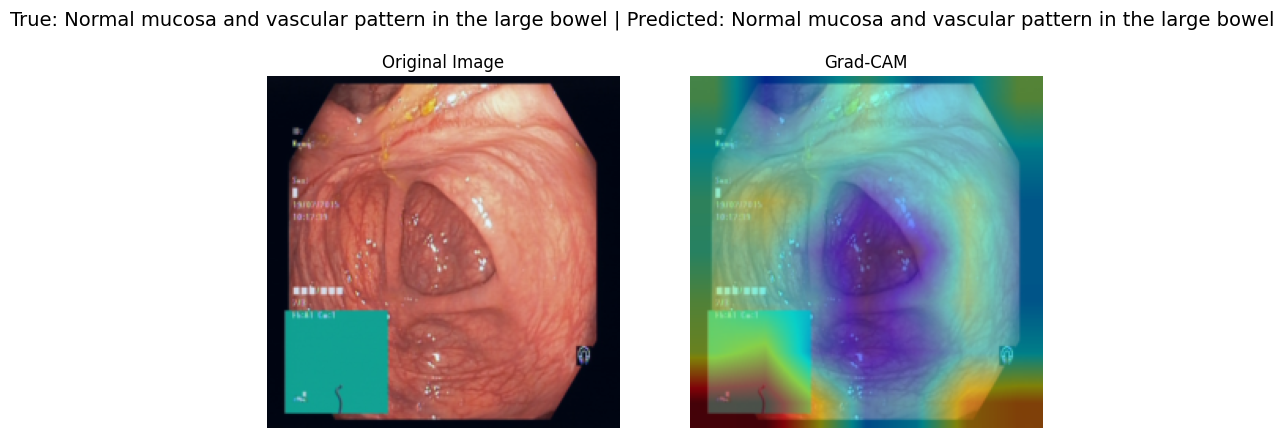

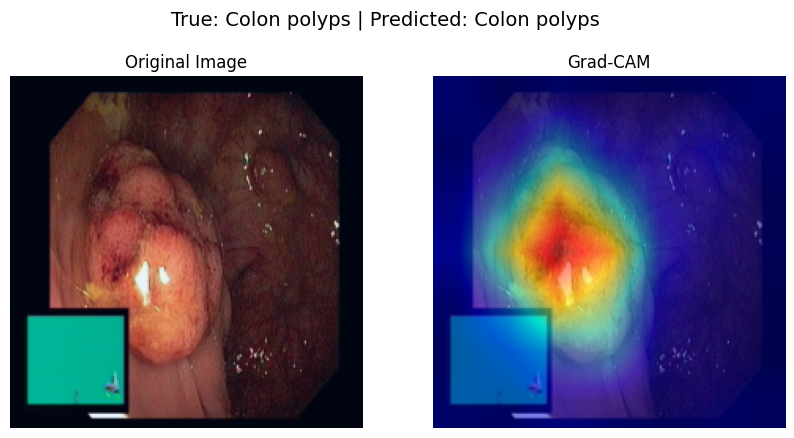

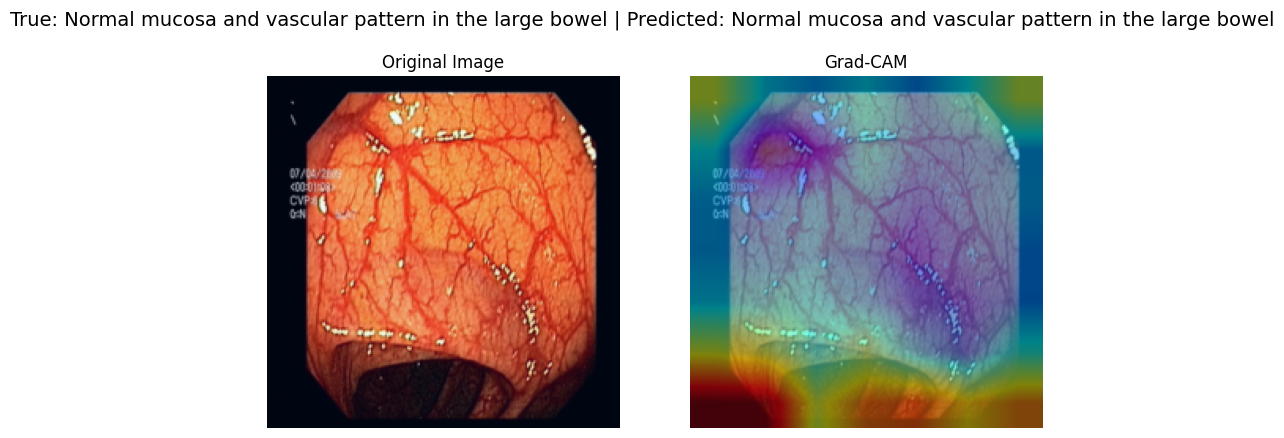

In [40]:
generate_gradcam(model, val_ds, index=4, target_layers=target_layers, class_names=full_dataset.classes)
generate_gradcam(model, val_ds, index=12, target_layers=target_layers, class_names=full_dataset.classes)
generate_gradcam(model, val_ds, index=26, target_layers=target_layers, class_names=full_dataset.classes)


In [37]:
misclassified = []

model.eval()
with torch.no_grad():
    for i in range(len(val_ds)):
        img, label = val_ds[i]
        output = model(img.unsqueeze(0).to(device))
        pred = output.argmax(1).item()
        if pred != label:
            misclassified.append(i)

misclassified[:10]   # show first 10


[7, 10, 14, 19, 33, 41, 45, 78, 104, 121]

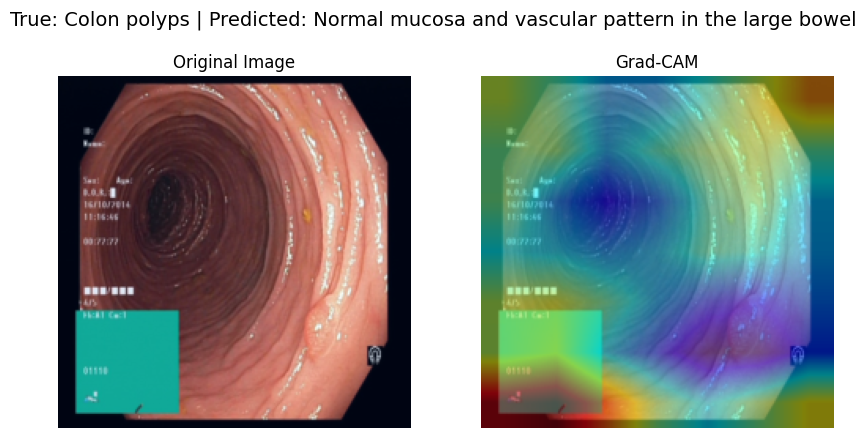

In [39]:
generate_gradcam(model, val_ds, misclassified[4], target_layers, full_dataset.classes)


In [42]:
torch.save(model.state_dict(), "/content/drive/MyDrive/gastrovision_best_model.pth")


In [45]:
# Find 1 sample index per class from val_ds
def get_one_sample_per_class(val_dataset, num_classes):
    indices = [-1] * num_classes
    for i in range(len(val_dataset)):
        _, label = val_dataset[i]
        if indices[label] == -1:
            indices[label] = i
        if all(idx != -1 for idx in indices):
            break
    return indices

sample_indices = get_one_sample_per_class(val_ds, len(full_dataset.classes))
sample_indices


[11, 248, 29, 0]

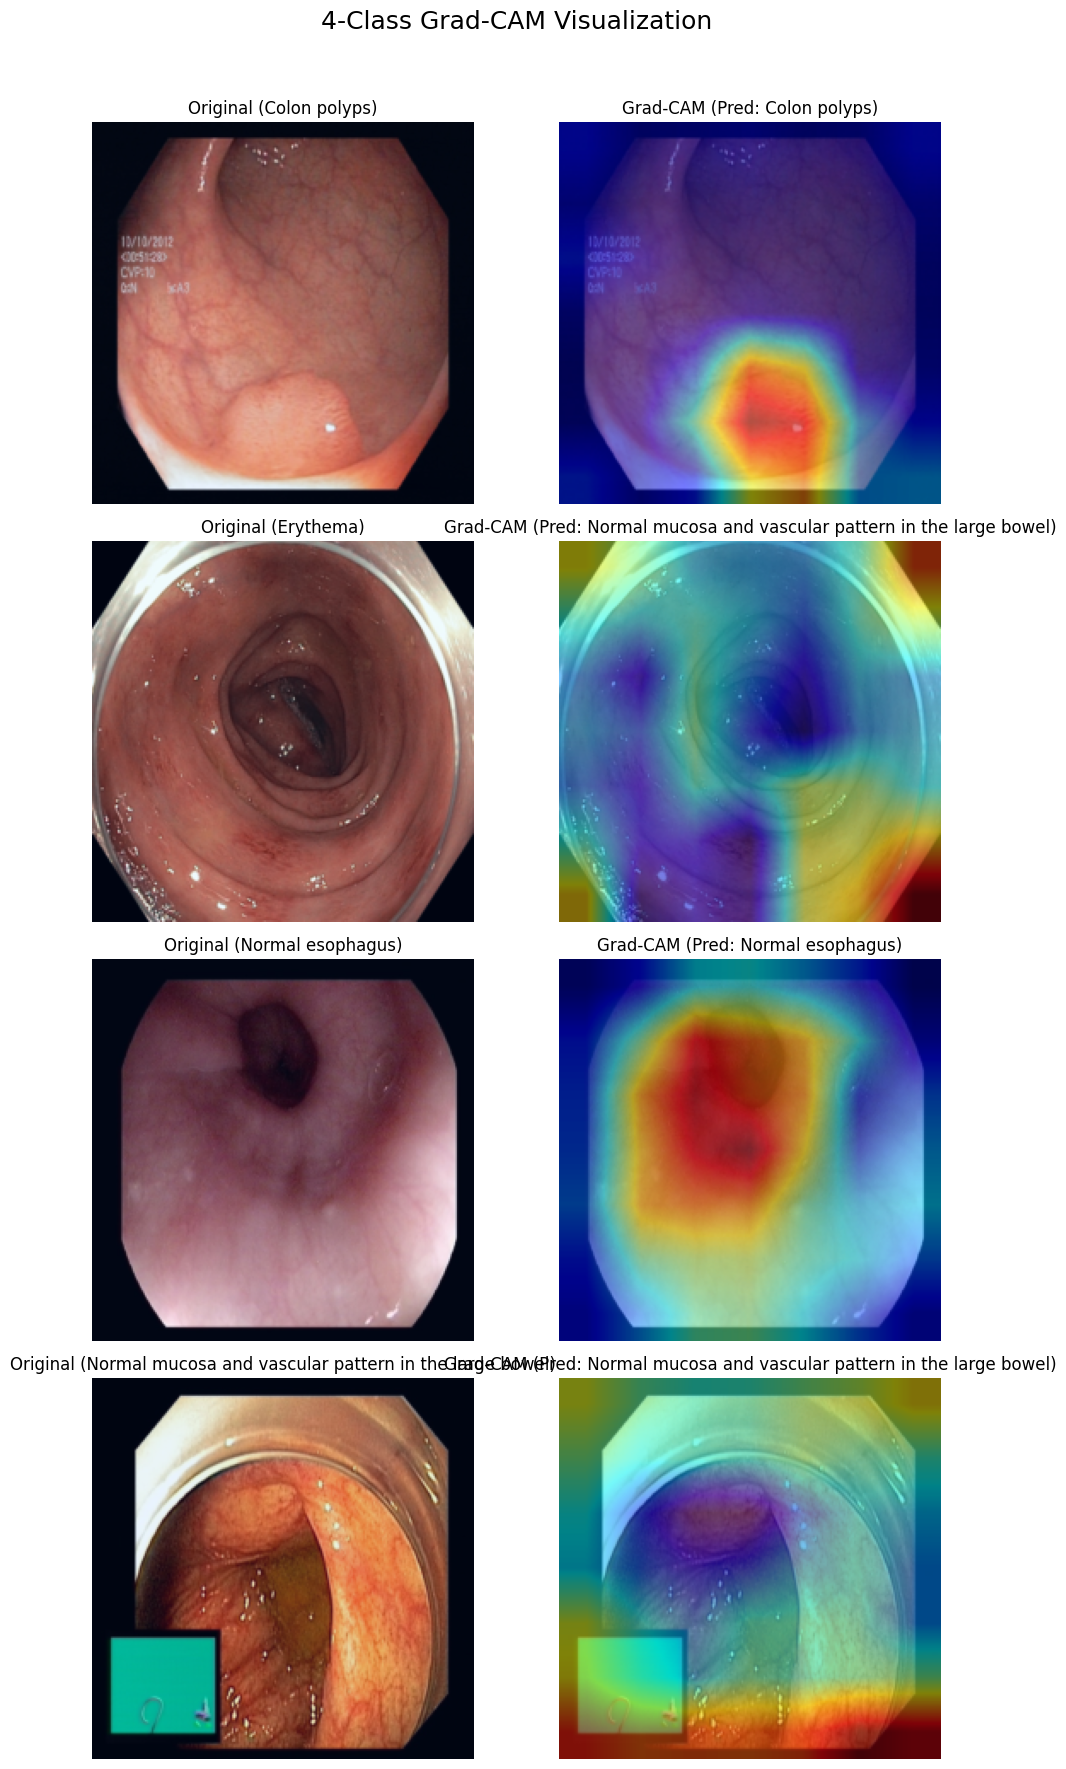

In [50]:
import matplotlib.pyplot as plt

def gradcam_image(model, dataset, index, target_layers):
    img, label = dataset[index]

    rgb = img.permute(1, 2, 0).numpy()
    rgb_norm = (rgb - rgb.min()) / (rgb.max() - rgb.min())

    input_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        out = model(input_tensor)
        pred = out.argmax(1).item()

    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred)])[0]

    heatmap = show_cam_on_image(rgb_norm, grayscale_cam, use_rgb=True)
    return rgb_norm, heatmap, label, pred


# ---------- Create collage ----------
fig, axes = plt.subplots(4, 2, figsize=(10, 18))
plt.suptitle("4-Class Grad-CAM Visualization", fontsize=18)

for class_id, idx in enumerate(sample_indices):
    orig, cam_img, true_label, pred_label = gradcam_image(
        model, val_ds, idx, target_layers
    )

    axes[class_id, 0].imshow(orig)
    axes[class_id, 0].set_title(f"Original ({full_dataset.classes[true_label]})")
    axes[class_id, 0].axis("off")

    axes[class_id, 1].imshow(cam_img)
    axes[class_id, 1].set_title(f"Grad-CAM (Pred: {full_dataset.classes[pred_label]})")
    axes[class_id, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
fig.savefig("/content/GastroVision/gradcam_collage.png", dpi=300)